# Elements of quantum error correction



## Bit-flip repetition code

In [1]:
import cirq, numpy as np, matplotlib.pyplot as plt, random
def build_encode(n):
    q = cirq.LineQubit.range(n)
    circuit = cirq.Circuit()
    for i in range(1,n):
        circuit.append(cirq.CNOT(q[0], q[i]))
    return q, circuit

n_demo = 5
q_demo, encode_demo = build_encode(n_demo)
print(encode_demo)

0: ───@───@───@───@───
      │   │   │   │
1: ───X───┼───┼───┼───
          │   │   │
2: ───────X───┼───┼───
              │   │
3: ───────────X───┼───
                  │
4: ───────────────X───


In [2]:
def apply_bitflip_noise(c, qubits, p):
    noisy = c.copy()
    for qb in qubits:
        noisy.append(cirq.BitFlipChannel(p).on(qb))
    return noisy

def parity_syndrome(bits):
    return np.array([bits[i]^bits[i+1] for i in range(len(bits)-1)],dtype=int)

p_demo = 0.2
sim = cirq.Simulator()
full_circuit = encode_demo + apply_bitflip_noise(cirq.Circuit(), q_demo, p_demo)
full_circuit.append(cirq.measure(*q_demo, key='m'))
print('\nFull circuit:')
print(full_circuit)
res = sim.run(full_circuit)
bits = res.measurements['m'][0]
print('\nMeasurement bits:', bits)
syndrome = parity_syndrome(bits)
print('Parity syndrome:', syndrome)


Full circuit:
0: ───@───@───@───@───BF(0.2)───M('m')───
      │   │   │   │             │
1: ───X───┼───┼───┼───BF(0.2)───M────────
          │   │   │             │
2: ───────X───┼───┼───BF(0.2)───M────────
              │   │             │
3: ───────────X───┼───BF(0.2)───M────────
                  │             │
4: ───────────────X───BF(0.2)───M────────

Measurement bits: [0 0 1 0 0]
Parity syndrome: [0 1 1 0]


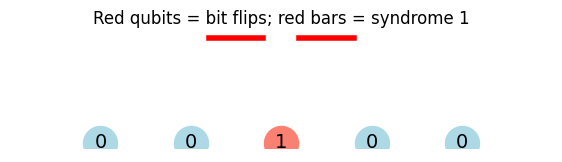

In [3]:
fig,ax=plt.subplots(figsize=(7,1.5)); ax.set_axis_off()
x=np.arange(n_demo)
for i,b in enumerate(bits):
    ax.scatter(i,0,s=600,color='salmon' if b else 'lightblue')
    ax.text(i,0,str(b),ha='center',va='center',fontsize=14)
for i,s in enumerate(syndrome):
    if s:
        ax.plot([i+0.2,i+0.8],[0.15,0.15],color='red',lw=4)
ax.set_xlim(-1,n_demo); ax.set_title('Red qubits = bit flips; red bars = syndrome 1');

In [4]:
def majority(bits):
    return int(np.sum(bits) > len(bits)/2)

logical_demo = majority(bits)
print('Logical readout (majority) =', logical_demo)

Logical readout (majority) = 0


## Majority voting and Parity Checks + MWPM are equivalent

In [5]:
def majority(bits):
    return int(bits.sum() > len(bits)/2)

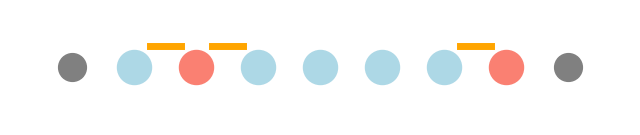

In [6]:
import numpy as np, matplotlib.pyplot as plt, random
def sample_bits(n,p): return np.array([random.random()<p for _ in range(n)])
def syndrome(bits): return np.array([bits[i]^bits[i+1] for i in range(len(bits)-1)])
def draw_shot(bits):
    n=len(bits); syn=syndrome(bits)
    x=np.arange(n)
    fig,ax=plt.subplots(figsize=(8,1.5)); ax.set_axis_off()
    for i,b in enumerate(bits):
        ax.scatter(i,0,s=600,color='salmon' if b else 'lightblue')
    for i,s in enumerate(syn):
        if s: ax.plot([i+0.25,i+0.75],[0.15,0.15],color='orange',lw=5)
    ax.scatter(-1,0,s=400,color='grey'); ax.scatter(n,0,s=400,color='grey')
    ax.set_xlim(-2,n+1); ax.set_ylim(-0.4,0.4)
draw_shot(sample_bits(7,0.2))

In [7]:
def mwpm_1d(syn):
    n=len(syn)+1
    e=np.zeros(n,dtype=int)
    for i in range(1,n):
        e[i]=e[i-1]^syn[i-1]
    w=e.sum()
    return e if w<=n-w else 1-e

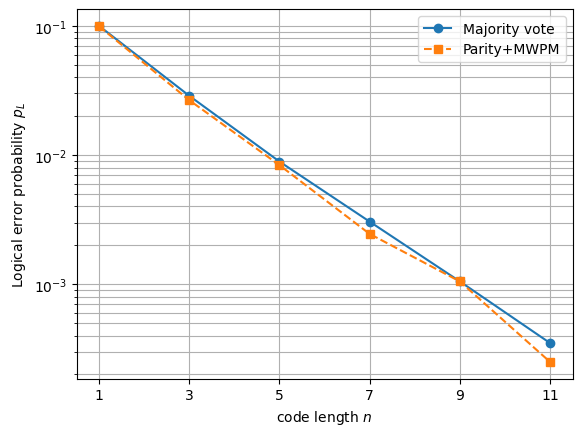

In [8]:
import matplotlib.pyplot as plt, math
def mc_rate(n,p,dec,shots=20000):
    fails=0
    for _ in range(shots):
        b=sample_bits(n,p)
        if dec=='major':
            fails+=majority(b)
        else:
            corr=mwpm_1d(syndrome(b))
            fails+=majority(b^corr)
    return fails/shots
p=0.1; ns=[1,3,5,7,9,11]
maj=[mc_rate(n,p,'major') for n in ns]
mw=[mc_rate(n,p,'mw') for n in ns]
plt.semilogy(ns,maj,'o-',label='Majority vote')
plt.semilogy(ns,mw,'s--',label='Parity+MWPM')
plt.xticks([1,3,5,7,9,11,])
plt.xlabel('code length $n$'); plt.ylabel('Logical error probability $p_L$'); #plt.title(f'p={p}')
plt.grid(True,which='both'); plt.legend();

## Analytical expression for logical error vs monte-carlo sims vs circuit-level sims are all the same (and work for both even and odd cases, just even has nuances)

Code length $n = 2d-1$, so the **majority threshold** is $d = \frac{n+1}{2}$.

---

1. **Choose which $i$ qubits flip.**  
$
\text{\# ways} \;=\; \binom{n}{i}.
$

2. **Assign a probability to that pattern.**  
Each selected qubit flips with probability $p$; each untouched qubit stays
correct with probability $(1-p)$:
$
\Pr(\text{that pattern}) \;=\; p^{i}\,(1-p)^{n-i}.
$

3. **Identify when decoding fails.**  
Majority fails iff the number of flips is **at least** $d$:
$
i \;\ge\; d = \frac{n+1}{2}.
$

4. **Sum over all failing patterns.**  
$
p_{L}(n,p)
\;=\;
\sum_{i=d}^{n}
\binom{n}{i}\,
p^{i}\,(1-p)^{n-i}.
$

5. For small $p$ the first term dominates, so
$
p_{L}(n,p)
\;\approx\;
\binom{n}{d}\,p^{d},
\qquad
\text{scaling like } p^{d}.
$

Abe note to self: 
*Distance* $d$ equals “minimum flips to fool majority,” so logical error decays as $p^{d}$ when $p\ll 1$.  Every increment in distance raises the suppression power by one order in $p$.

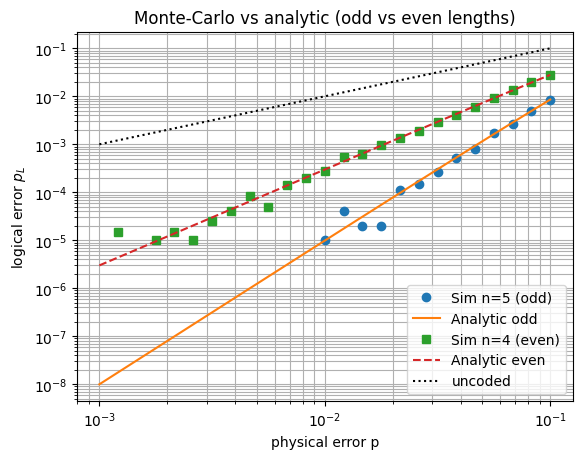

In [9]:
import numpy as np, matplotlib.pyplot as plt, random
from math import comb

def logical_error_formula(n, p):
    k = n // 2 + 1                     
    tail = sum(comb(n,i)*p**i*(1-p)**(n-i) for i in range(k, n+1))
    if n % 2 == 0:                     
        t = n // 2
        tail += 0.5 * comb(n,t) * p**t * (1-p)**t
    return tail

def mc_logical_error(n, p, shots=100_000):
    fail = 0
    for _ in range(shots):
        flips = sum(random.random() < p for _ in range(n))
        if flips > n/2:
            fail += 1  # majority of 1’s -> logical error
        elif flips == n/2 and n % 2 == 0:
            fail += 0.5  # tie -> half failure prob
    return fail / shots

# compare odd and even, sim and analytical
n_odd, n_even = 5, 4
ps = np.logspace(-3, -1, 25)

sim_odd  = [mc_logical_error(n_odd,  p) for p in ps]
sim_even = [mc_logical_error(n_even, p) for p in ps]
ana_odd  = [logical_error_formula(n_odd,  p) for p in ps]
ana_even = [logical_error_formula(n_even, p) for p in ps]

plt.loglog(ps, sim_odd,  'o', label=f'Sim n={n_odd} (odd)')
plt.loglog(ps, ana_odd,  '-', label='Analytic odd')
plt.loglog(ps, sim_even, 's', label=f'Sim n={n_even} (even)')
plt.loglog(ps, ana_even, '--', label='Analytic even')
plt.loglog(ps, ps, ':k',  label='uncoded')
plt.xlabel('physical error p'); plt.ylabel('logical error $p_L$')
plt.title('Monte-Carlo vs analytic (odd vs even lengths)')
plt.legend(); plt.grid(True, which="both")



0: ───@───@───
      │   │
1: ───X───┼───
          │
2: ───────X───
0: ───@───@───@───@───
      │   │   │   │
1: ───X───┼───┼───┼───
          │   │   │
2: ───────X───┼───┼───
              │   │
3: ───────────X───┼───
                  │
4: ───────────────X───
0: ───@───@───@───@───@───@───
      │   │   │   │   │   │
1: ───X───┼───┼───┼───┼───┼───
          │   │   │   │   │
2: ───────X───┼───┼───┼───┼───
              │   │   │   │
3: ───────────X───┼───┼───┼───
                  │   │   │
4: ───────────────X───┼───┼───
                      │   │
5: ───────────────────X───┼───
                          │
6: ───────────────────────X───
0: ───@───@───@───@───@───@───@───@───
      │   │   │   │   │   │   │   │
1: ───X───┼───┼───┼───┼───┼───┼───┼───
          │   │   │   │   │   │   │
2: ───────X───┼───┼───┼───┼───┼───┼───
              │   │   │   │   │   │
3: ───────────X───┼───┼───┼───┼───┼───
                  │   │   │   │   │
4: ───────────────X───┼───┼───┼───┼───
           

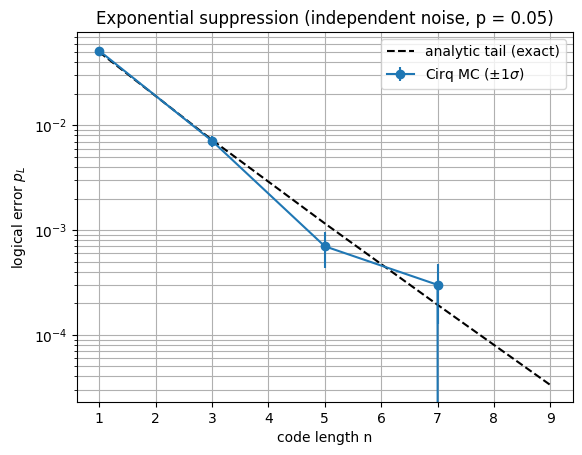

In [10]:
import cirq, numpy as np, matplotlib.pyplot as plt, random
from math import comb
import math

def logical_tail(n, p):
    d = (n + 1)//2
    return sum(comb(n,i)*p**i*(1-p)**(n-i) for i in range(d, n+1))

def build_encode_circuit(n):
    q = cirq.LineQubit.range(n)
    c = cirq.Circuit()
    for i in range(1, n):
        c.append(cirq.CNOT(q[0], q[i]))
    return q, c

def majority(bits):
    return int(bits.sum() > len(bits) / 2)

def logical_error_cirq(n, p, shots=10000):
    q, enc = build_encode_circuit(n)
    print(enc)
    sim = cirq.Simulator()
    fails = 0
    for _ in range(shots):
        # fresh copy each shot
        circ = enc.copy()
        # independent X-noise
        circ += [cirq.BitFlipChannel(p).on(qb) for qb in q]
        circ.append(cirq.measure(*q, key='m'))
        bits = sim.run(circ, repetitions=1).measurements['m'][0]
        fails += majority(bits)
    return fails / shots


n_shots = 10000
p_phys = 5e-2
ns = [1, 3, 5, 7, 9]
logical = []; err = []
for n in ns:
    rate = logical_error_cirq(n, p_phys, shots=n_shots)
    logical.append(rate)
    # binomial error
    err.append(math.sqrt(rate*(1-rate)/n_shots))

plt.errorbar(ns, logical, yerr=err, fmt='o-', label=r'Cirq MC $(\pm1\sigma)$')
plt.semilogy(ns, [logical_tail(n, p_phys) for n in ns],
             'k--', label='analytic tail (exact)')
plt.xlabel('code length n'); plt.ylabel('logical error $p_L$')
plt.title(f'Exponential suppression (independent noise, p = {p_phys})')
plt.grid(True, which='both'); plt.legend(); plt.show()

## TODO: Adapting the rep code for phase flips

## TODO: Combining bit and phase flips: Shor code